In [1]:
from joblib import load
from warnings import filterwarnings
import os
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline, make_pipeline

from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
set_config(transform_output="pandas")

from src.data_transform import *
from src.visuals import *
from src.experiment_utils import (RANDOM_STATE, create_models, imputation_test, cat_encoding_test, feature_selection_test, 
                                  grid_search, randomized_search, summarize_results, evaluate_discrimination_thresholds)
from src.utils import load_estimators, display_final_results

In [2]:
file_path = os.path.join("data", "Train_nyOWmfK.csv")
data = pd.read_csv(file_path, encoding = "ISO-8859–1")

In [3]:
data.head(3)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0


# Data exploration

The data was collected over a three-month period in 2015.

The dataset includes **26 columns** and **87 020 entries**.


It consists of:
* 13 numerical features
    * 11 continous
    * 2 binary (LoggedIn, **Disbursed - target variable**)
* 13 non-numerical features


There are 11 features in which missing values occur.

The **ID** column contains unique values for each sample and cannot be used for prediction.
The **LoggedIn** column is for problem understanding purposes and cannot be used for prediction.

The meaning of **Var1**, **Var2**, **Var4**, **Var5** and **Source** is unknown.

### Missing values

* There are many missing (NaN) values in the dataset. 
* Numerous zero values in some features can be considered as additional missing values (Loan_Amount_Applied, Loan_Tenure_Applied, Employer_Name).

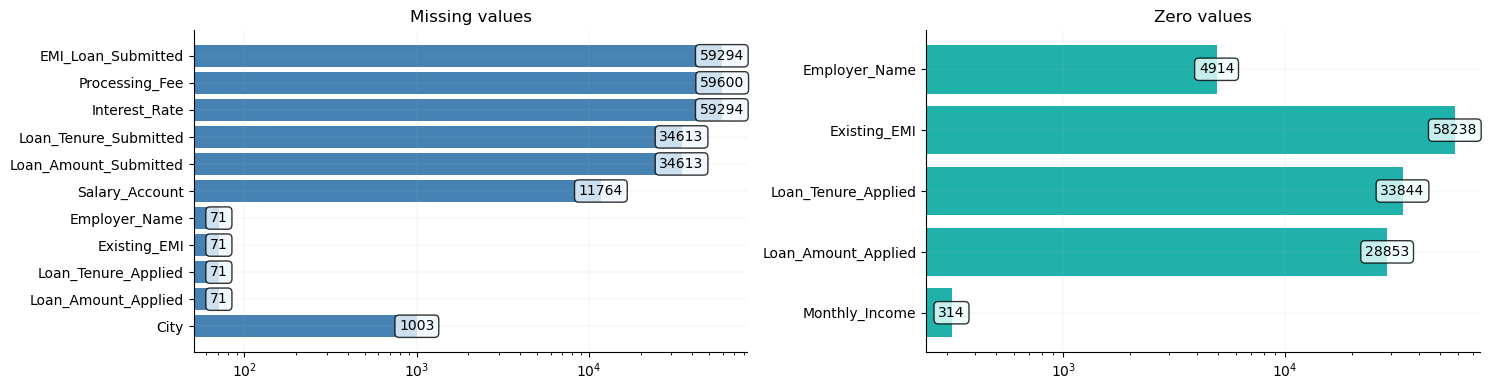

In [4]:
missings_plot(data)

* It was assumed that at least the majority of missing values are not random.
* It was verified that there are **corresponding missing values in three sets of columns (as seen above)**. This may reflect the processing stages of the loan application procedure. It's not necessary for all of them to be completed to receive a loan, although the percentage of disbursements among samples without missing values is higher.
* The missing values in **City** column may indicate a lack of a permanent place of residence.
* There are a lot of missing values in **Salary_Account** column, but the presence of this information does not seem to matter.
* Zeros in **Existing_EMI** probably indicate a lack of other debts, while zeros in **Monthly_Income** may signify an irregular income.

### Categorical variables

In [5]:
data.describe(include = ['O'])

,ID,Gender,City,DOB,Lead_Creation_Date,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,87020,87020,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,11345,92,43567,57,2,19,2,2,7,30
top,ID000002C20,Male,Delhi,11-Nov-80,03-Jul-15,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,306,2315,4914,17695,56481,59294,67530,64316,37280,38567


There are 13 categorical features:

* 2 with **dates** (DOB, Lead_Creation_Date)
* 7 categorical with **multiple levels** (ID, City, Employer_Name, Salary_Account, Var1, Var2, Source)
* 4 **binary** categorical (Gender, Mobile_Verified, Filled_Form, Device_Type)

As seen below, multicategorical features have rare values, that can be aggregated in various ways.

In [6]:
data["City"].value_counts().reset_index()

,City,count
0,Delhi,12527
1,Bengaluru,10824
2,Mumbai,10795
3,Hyderabad,7272
4,Chennai,6916
...,...,...
692,Lalitpur,1
693,Kandhamal,1
694,Sawai Madhopur,1
695,Munger,1


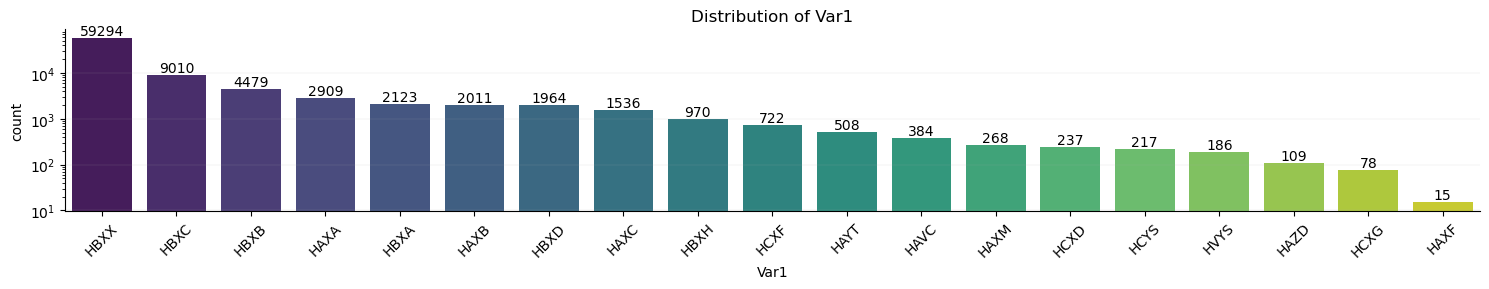

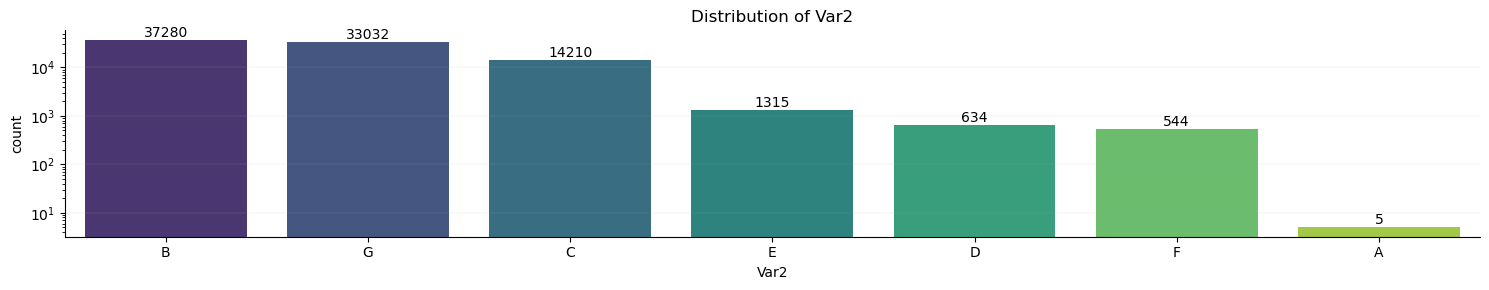

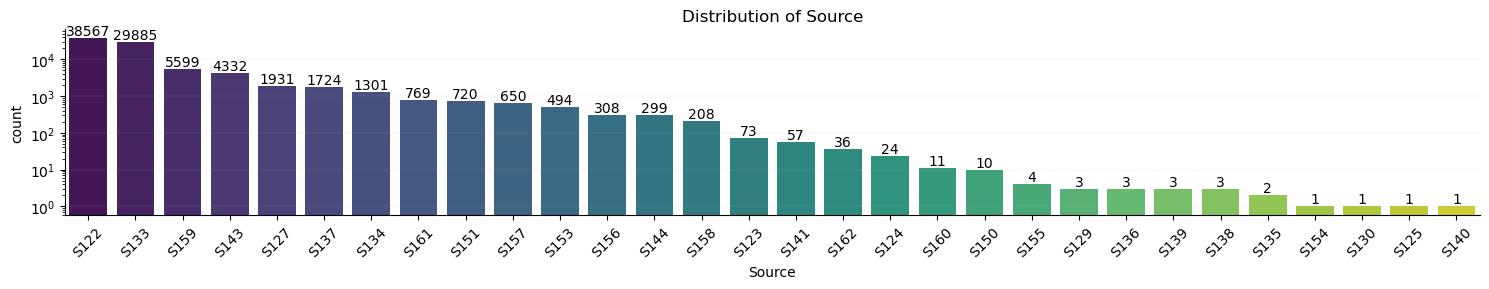

In [7]:
countplots("Var1", "Var2", "Source", data = data)

### Numerical variables

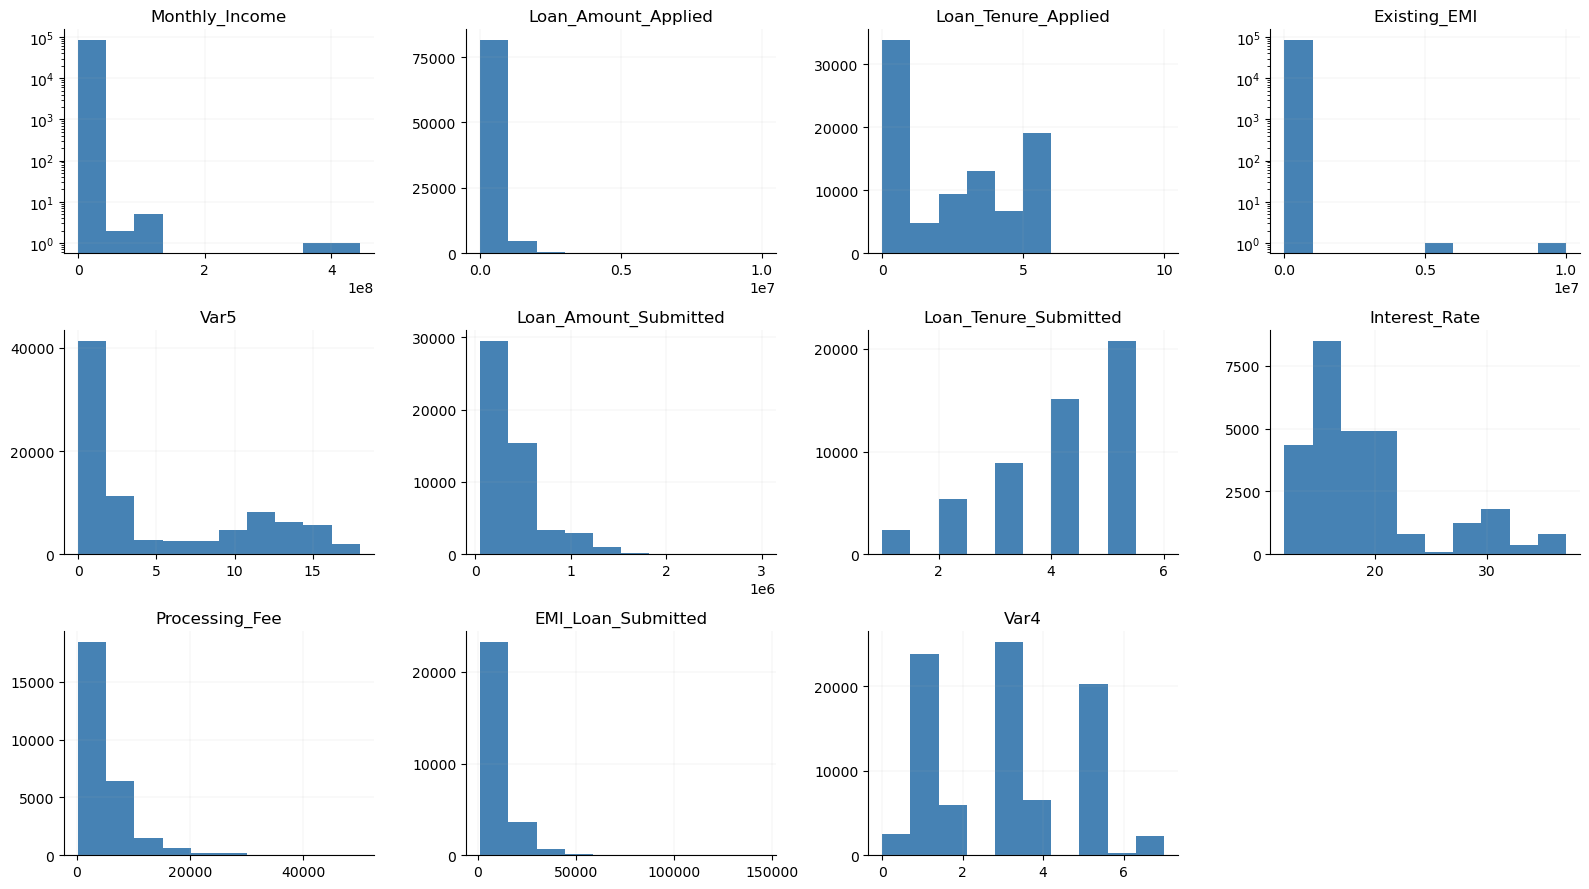

In [8]:
histplots_grid(3, 4, data)

There are 11 continous features.

As seen above, the features display different distributions and varying value ranges. It can be explored the option of applying transformations to bring these values closer to a normal distribution or scale them, especially when using methods that require such transformations. However, these transformations are not necessary when using tree-based algorithms.

### Target variable

In [9]:
data.Disbursed.value_counts(normalize=True).round(4)

Disbursed
0    0.9854
1    0.0146
Name: proportion, dtype: float64

In this dataset, highly imbalanced classes are present. 
The following strategies were adopted to address this issue:

* stratified train_test_split
* stratified KFold for cross-validation
* increasing the weight of the minority class or resampling within balanced ensemble models

# Experiments

## First data version

* **ID**, **Lead_Creation_Date**, **Device_Type**, **Salary_Account** columns removed, since their use in prediction does not seem to make sense.

* **City** column cransformation: from 698 to 3 categories using current [Indian cities classification](https://en.wikipedia.org/wiki/Classification_of_Indian_cities) by population size, leaving missing values unchanged. Renamed to **City_Size**. 

* **Employer_Name** column transformation: into 1/0, as it was considered that the employer name is not important, but the fact of providing or not providing this information during the application process may be significant. Renamed to **Employer_Provided**.

* **DOB** column cransformation: from date of birth to age. Renamed to **Age**.

* **Var1, Var2, Source** - rare values aggregated as "Others" using a threshold of 1000 occurrences.

* Numerical variables and missing values were retained, except filling 71 corresposponding missings in **Loan_Amount_Applied, Loan_Tenure_Applied, Existing_EMI** with 0.

In [10]:
X, y = data_preparing(data)

X.shape, y.shape

((87020, 20), (87020,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)
X_train.head(3)

,Gender,City_Size,Monthly_Income,Age,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Provided,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Var2,Source,Var4
26733,Female,Tier_1,50000,39,1000000.0,5.0,0.0,1,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,B,S133,3
81500,Female,Tier_1,17475,26,200000.0,3.0,4732.0,1,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,G,S122,3
81659,Female,Tier_2,52000,53,0.0,0.0,0.0,1,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,G,S122,3


**The main goal of this stage is to track the behavior of models with different types of basic transformations and select the models that achieve the best results.**

Tree-based ensembles were applied:

* BaggingClassifier,
* HistGradientBoostingClassifier,
* RandomForestClassifier,
* BalancedBaggingClassifier with RandomUnderSampler,
* BalancedBaggingClassifier with RandomOverSampler,
* BalancedRandomForestClassifier,
* EasyEnsembleClassifier
 
in their default and slightly modified parameter configurations.

The tests were conducted using **stratified, shuffled 5 fold cross-validation on the training set**.

In [12]:
base_models = [
    BaggingClassifier(),
    HistGradientBoostingClassifier(),
    RandomForestClassifier(),
    BalancedBaggingClassifier(sampler = RandomUnderSampler(random_state=RANDOM_STATE)),
    BalancedBaggingClassifier(sampler = RandomOverSampler(random_state=RANDOM_STATE)),
    BalancedRandomForestClassifier(sampling_strategy = "auto", replacement = True),
    EasyEnsembleClassifier()
]

n_estimators, max_samples, max_features = 100, 0.5, 0.5

params_list = [
    [
        {"estimator": DecisionTreeClassifier(class_weight = {1:50}, min_samples_leaf = 20), 
         "n_estimators": n_estimators, "max_samples": max_samples},
        {"estimator": DecisionTreeClassifier(class_weight = {1:100}, min_samples_leaf = 50), 
         "n_estimators": n_estimators}],
    [
        {"class_weight": {1:20}},
        {"class_weight": {1:50}, "min_samples_leaf": 50}],
    [
        {"class_weight": {1:50}, "min_samples_leaf": 20, "max_samples": 0.3, "max_features": max_features},
        {"class_weight": {1:100}, "min_samples_leaf": 50, "max_samples": 0.6, "max_features": 1.0}],
    [
        {"n_estimators": n_estimators, "replacement": True},
        {"n_estimators": n_estimators, "replacement": True, "max_features": max_features}],
    [
        {"n_estimators": 50},
        {"n_estimators": n_estimators, "max_samples": max_samples, "max_features": max_features}],
    [
        {"max_features": 1.0},
        {"min_samples_leaf": 20, "max_features": max_features}],
    [
        {"n_estimators": 20, "estimator": AdaBoostClassifier(learning_rate = 0.1), "replacement": True},
        {"n_estimators": n_estimators, "replacement": True}]
]

models = create_models(base_models, params_list)

### Missing values imputation tests

In this section, tests were conducted with various methods of handling missing values. The following were tested:

* imputation with an out-of-range value (-1) by **Simple Imputer**,
* **KNN Imputer** (preceded by scaling for better performance),
* experimental **Iterative Imputer** (preceded by power transformation for better performance),
* **the lack of imputation** was checked for models that support it.

**One-hot encoding** was applied to categorical features.

In [13]:
results_imp_path = os.path.join("results_data", "experiments_csv", "imputation_test_results.csv")

In [14]:
num_preprocessors = [
            ("SimpleImputer",
             SimpleImputer(strategy = "constant", 
                           fill_value = -1)), 
            ("KNNImputer",
             make_pipeline(MinMaxScaler(),
                           KNNImputer())), 
            ("IterativeImputer",
             make_pipeline(PowerTransformer(),
                           IterativeImputer(sample_posterior = True,
                                            random_state = RANDOM_STATE))),
            ("none", "passthrough")
]

results_imp = imputation_test(X_train, y_train, 
                              models, 
                              preprocessors = num_preprocessors, 
                              save_results_path = results_imp_path)

In [15]:
# results_imp = pd.read_csv(results_imp_path)

results_imp.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Time[s],Imputation
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8482,1.82,none
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8474,6.07,IterativeImputer
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8459,1.75,SimpleImputer
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 50",0.8457,1.49,none
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8446,299.98,KNNImputer


In [16]:
summarize_results(results_imp, column_to_group_by = "Imputation")

,count,max_roc_auc,mean_roc_auc,min_roc_auc,mean_time[s],min_time[s],max_time[s]
Imputation,,,,,,,
none,12,0.848200,0.824500,0.783900,4.640000,0.470000,18.730000
IterativeImputer,21,0.847400,0.805400,0.626400,10.330000,4.980000,32.180000
SimpleImputer,21,0.845900,0.803800,0.614000,5.220000,0.550000,28.440000
KNNImputer,21,0.844600,0.803500,0.620100,299.200000,290.050000,320.030000


The best results were achieved without imputation, with the next best being obtained using HistGradientBoostingClf with Iterative Imputer. However, not all models support lack of imputation. For most models, Simple Imputer performed the best and was significantly faster than Iterative Imputer. Therefore, Simple Imputer will be used for subsequent tests, although imputation may be omitted in later stages. KNN Imputer showed the worst performance and was also considered unacceptable due to its long execution time.

### Category encoders tests

In this section, tests were conducted with various methods of encoding categorical features. The following were tested:

* **one-hot encoding**,
* **target encoding**,
* **dropping categorical features**

Missing values in numerical columns were filled with the vallue -1 using Simple Imputer.
For the categorical column City_Size, the missing values are encoded as a separate category.

In [17]:
results_enc_path = os.path.join("results_data", "experiments_csv", "cat_encoding_test_results.csv")

In [18]:
cat_preprocessors = [
    ("OneHotEncoder", OneHotEncoder(sparse_output = False)),
    ("TargetEncoder", TargetEncoder(random_state = RANDOM_STATE)),
    ("dropped", "drop")
]

results_enc = cat_encoding_test(X_train, y_train, 
                                models, 
                                preprocessors = cat_preprocessors, 
                                save_results_path = results_enc_path)

In [19]:
# results_enc = pd.read_csv(results_enc_path)

results_enc.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Time[s],Encoder
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8459,1.71,OneHotEncoder
HistGradientBoostingClassifier,"class_weight: None, min_samples_leaf: 20",0.8452,0.96,TargetEncoder
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8451,1.15,TargetEncoder
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None, max_features: 1.0",0.8445,1.62,OneHotEncoder
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None, max_features: sqrt",0.8444,1.46,TargetEncoder


In [20]:
summarize_results(results_enc, column_to_group_by = "Encoder")

,count,max_roc_auc,mean_roc_auc,min_roc_auc,mean_time[s],min_time[s],max_time[s]
Encoder,,,,,,,
OneHotEncoder,21,0.845900,0.803800,0.614000,5.120000,0.530000,28.210000
TargetEncoder,21,0.845200,0.809500,0.622700,3.810000,0.380000,24.170000
dropped,21,0.834000,0.789600,0.615400,2.950000,0.230000,23.050000


The method of encoding categorical features did not have a significant impact on the results. Depending on the model, either one-hot encoding or target encoding performed better. The highest score in the test was achieved using OHE, but the average performance is better with target encoding. Due to the minor differences in performance and easier column management, target encoding will be used for subsequent tests. Furthermore, excluding categorical features only slightly deteriorated the results.

### Feature selection tests

While there are only 20 variables, the meaning of 5 of them is unknown, which is why such a test was conducted. Additionally, following the previous test, there is a suspicion that some features might not be very important.

Feature selection based on importance weights was applied. Missing values in numerical columns were filled with the value -1 using Simple Imputer.
For the categorical columns, target encoding was used.

#### Estimator optimization

**Random Forest Classifier** with best found parameters was used as the feature selection estimator.

In [21]:
best_forest_path = os.path.join("results_data", "artifacts", "feature_selection", "best_forest.pkl")

In [22]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs = -1)

param_grid = {"model__class_weight": [{1:75}, {1:100}],
              "model__n_estimators": [100, 200],
              "model__min_samples_leaf": [5, 20, 50, 100],
              "model__max_features": [0.2, 0.4, 0.6, 0.8],
              "model__max_samples": [0.2, 0.4, 0.6, 0.8]}

best_score = grid_search(X_train, y_train,
                         model,
                         param_grid, 
                         best_forest_path)
best_score

0.8477

#### Feature selection

In [23]:
results_fs_path = os.path.join("results_data", "experiments_csv", "feature_selection_test.csv")

In [24]:
best_forest = load(best_forest_path)
thresholds = [0.01, 0.014, 0.016, 0.018, 0.019, 0.02, 0.025, 0.035]

results_fs = feature_selection_test(X_train, y_train,
                                    models,
                                    estimator = best_forest,
                                    selection_thresholds = thresholds,
                                    save_results_path = results_fs_path)

In [25]:
# results_fs = pd.read_csv(results_fs_path)

results_fs.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Time[s],Threshold,Selected[%],Rejected[idx]
Model,,,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8452,2.53,0.014,95.0,[5]
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8450,2.60,0.016,85.0,"[5, 10, 15]"
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None, max_features: sqrt",0.8447,2.98,0.020,60.0,"[5, 8, 10, 11, 12, 13, 15, 17]"
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 20",0.8446,2.64,0.019,70.0,"[5, 8, 10, 11, 15, 17]"
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None, max_features: sqrt",0.8444,3.00,0.016,85.0,"[5, 10, 15]"


In [26]:
summarize_results(results_fs, column_to_group_by = "Selected[%]")

,count,max_roc_auc,mean_roc_auc,min_roc_auc,mean_time[s],min_time[s],max_time[s]
Selected[%],,,,,,,
95.000000,21,0.845200,0.808900,0.627400,5.300000,1.900000,26.000000
85.000000,21,0.845000,0.808400,0.624500,5.150000,1.750000,25.850000
60.000000,21,0.844700,0.805600,0.618400,4.970000,1.990000,24.980000
70.000000,21,0.844600,0.807300,0.618600,5.060000,1.990000,24.910000
100.000000,21,0.844100,0.808700,0.624200,5.240000,1.880000,25.150000
75.000000,21,0.843700,0.807200,0.625500,5.020000,1.800000,25.130000
50.000000,21,0.840800,0.799400,0.615700,4.580000,1.930000,24.260000
35.000000,21,0.832000,0.789400,0.600400,4.290000,1.670000,23.780000


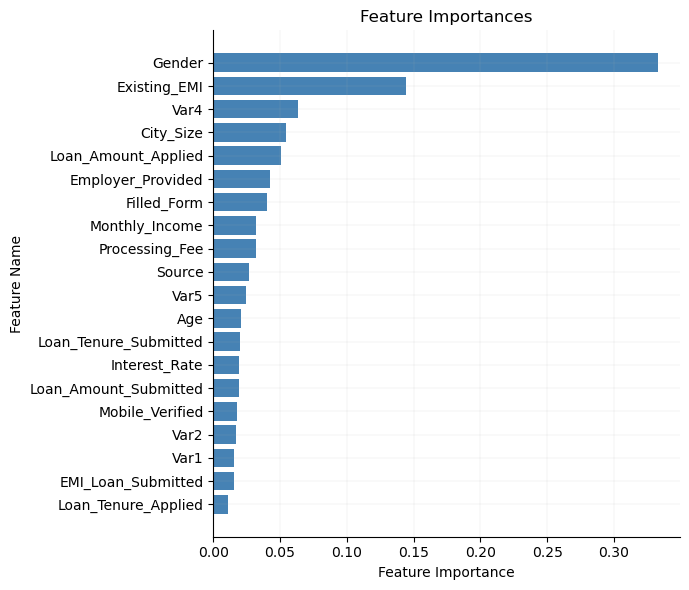

In [27]:
feature_importance_plot(best_forest.feature_importances_, X.columns)

The best results were achieved by retaining 60-100% of the features, depending on the model.

It was determined which features are the least important, and it was found that removing them does not significantly impact the results. Very high scores (above 0.84) were achieved even when only 50% of the features were selected. So it could also be checked if, after removing some columns, but with different hyperparameters for the models, the results will be better. It could also be tested other transformations of categorical columns, which may allow to extract more information from them.

### Summary of the first part of the tests

In [4]:
folder_path = os.path.join("results_data", "experiments_csv")

summarize_results("all_results", 
                  column_to_group_by = "Model", 
                  folder_path = folder_path)

,count,max_roc_auc,mean_roc_auc,min_roc_auc,mean_time[s],min_time[s],max_time[s]
Model,,,,,,,
HistGradientBoostingClassifier,45,0.848200,0.841400,0.830400,21.900000,0.670000,299.980000
BalancedRandomForestClassifier,42,0.844700,0.839600,0.830400,23.800000,1.210000,302.350000
RandomForestClassifier,42,0.843900,0.818500,0.750700,24.390000,1.120000,298.230000
BalancedBagging_UnderSampling,45,0.843800,0.829800,0.797500,22.570000,0.230000,301.870000
BaggingClassifier,45,0.841000,0.770700,0.618400,23.990000,0.430000,302.020000
EasyEnsembleClassifier,42,0.834900,0.829600,0.816800,33.000000,2.350000,320.030000
BalancedBagging_OverSampling,45,0.798300,0.706400,0.600400,27.920000,1.450000,315.430000


**A summary of all tests from this phase for the models** can be seen in the table above. For further testing, HistGradientBoostingClf, BalancedRandomForestClf, BalancedBaggingClf with undersampling, RandomForestClf were chosen, as they consistently provided the highest ROC_AUC scores in all tests. The worst results were achieved by BalancedBaggingClf with oversampling.

## Different data transformations and hyperparameters optimization

At this stage, it was returned to raw data in certain columns, and their transformations were performed using transformers within pipelines. The aim was to find the most advantageous data transformation and best hyperparameters.

In addition to the model's own hyperparameters, it was also tested: 
* various thresholds for grouping rare values in categorical features
* various ways of categorize "City" column (by frequency with different thresholds or grouping based on city population size)
* minor modifications or omission of missing value imputation
* removal of up to the 8 least important features
* the use or absence of power transformation

To encode categorical features, target encoding was applied for multilevel features, and one-hot encoding with drop-first was used for binary features. All tests were conducted using the same cross-validation scheme as before.

In [3]:
X, y = data_preparing(data, basic_preparing = True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((69616, 20), (69616,), (17404, 20), (17404,))

In [4]:
X_train.head(3)

,Gender,City,Monthly_Income,Age,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Provided,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Var2,Source,Var4
26733,Female,Delhi,50000,39,1000000.0,5.0,0.0,1,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,B,S133,3
81500,Female,Chennai,17475,26,200000.0,3.0,4732.0,1,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,G,S122,3
81659,Female,Noida,52000,53,0.0,0.0,0.0,1,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,G,S122,3


In [5]:
cat_pipe = Pipeline([
    ("aggreg", RareAggregator()),
    ("encoder", ColumnTransformer([
        ("multi", 
         TargetEncoder(random_state = RANDOM_STATE), ["City", "Var1", "Var2", "Source"]),
        ("binary", 
         OneHotEncoder(drop = "first", sparse_output = False), ["Gender", "Mobile_Verified", "Filled_Form"])
    ]))
])

num_pipe = Pipeline([
    ("imputer", MixedImputer()), 
    ("power_tran", PowerTransformer())
])

preprocessor = ColumnTransformer([
    ("num_pipe", num_pipe, selector(dtype_include="number")),
    ("cat_pipe", cat_pipe, selector(dtype_include="object"))
])

# final_pipeline = Pipeline([("preprocessor", preprocessor), 
#                            ("remover", ColumnRemover()), 
                           # ("model", model)])

In [6]:
preprocessor.fit_transform(X_train, y_train).head(3)

,num_pipe__Monthly_Income,num_pipe__Age,num_pipe__Loan_Amount_Applied,num_pipe__Loan_Tenure_Applied,num_pipe__Existing_EMI,num_pipe__Employer_Provided,num_pipe__Var5,num_pipe__Loan_Amount_Submitted,num_pipe__Loan_Tenure_Submitted,num_pipe__Interest_Rate,num_pipe__Processing_Fee,num_pipe__EMI_Loan_Submitted,num_pipe__Var4,cat_pipe__multi__City,cat_pipe__multi__Var1,cat_pipe__multi__Var2,cat_pipe__multi__Source,cat_pipe__binary__Gender_Male,cat_pipe__binary__Mobile_Verified_Y,cat_pipe__binary__Filled_Form_Y
26733,0.736105,1.297420,1.217608,1.238392,-0.699601,0.24664,1.348800,-1.216913,-1.178071,-0.682279,-0.676517,-0.682437,0.13088,0.022190,0.011458,0.016601,0.017119,0.0,0.0,0.0
81500,-0.478831,-0.531105,0.605921,0.627402,1.410446,0.24664,-0.445116,-1.216913,-1.178071,-0.682279,-0.676517,-0.682437,0.13088,0.009010,0.011458,0.013576,0.014639,0.0,0.0,0.0
81659,0.784759,2.190905,-1.374585,-1.150072,-0.699601,0.24664,1.248332,1.143368,1.121261,-0.682279,-0.676517,-0.682437,0.13088,0.010553,0.011458,0.013576,0.014639,0.0,1.0,0.0


In [7]:
base_models = [HistGradientBoostingClassifier(),
               BalancedRandomForestClassifier(sampling_strategy = "auto"),
               BalancedBaggingClassifier(),
               RandomForestClassifier()]

models = create_models(base_models) # setting random_state and n_jobs only

param_grids = [{"model__class_weight": [{1:10}, {1:20}, None],
                "model__min_samples_leaf": [20, 50, 100],
                "preprocessor__cat_pipe__aggreg__group_by": ["frequency", "tiers/freq", "big_cities/tiers/freq"],
                "preprocessor__cat_pipe__aggreg__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression", None],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6, 7, 8]},
               
               {"model__n_estimators": [100, 200],
                "model__min_samples_leaf": [1, 10, 20],
                "model__max_features": [0.3, 0.6, 1.0],
                "model__replacement": [True, False],
                "preprocessor__cat_pipe__aggreg__group_by": ["frequency", "tiers/freq", "big_cities/tiers/freq"],
                "preprocessor__cat_pipe__aggreg__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression"],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6, 7, 8]},

               {"model__n_estimators": [100, 200],
                "model__max_features": [0.5, 0.8, 1.0],
                "model__replacement": [True, False],
                "preprocessor__cat_pipe__aggreg__group_by": ["frequency", "tiers/freq", "big_cities/tiers/freq"],
                "preprocessor__cat_pipe__aggreg__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression", None],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6, 7, 8]},
                
               {"model__class_weight": [{1:75}, {1:100}],
                "model__n_estimators": [100, 200],
                "model__min_samples_leaf": [20, 50, 100],
                "model__max_features": [0.3, 0.6, 0.9],
                "model__max_samples": [0.2, 0.4, 0.6, 0.8],
                "preprocessor__cat_pipe__aggreg__group_by": ["frequency", "tiers/freq", "big_cities/tiers/freq"],
                "preprocessor__cat_pipe__aggreg__threshold": [600, 1000, 1500],
                "preprocessor__num_pipe__imputer__how": ["simple", "applied_submitted_compression"],
                "preprocessor__num_pipe__power_tran": [PowerTransformer(), "passthrough"],
                "remover__to_drop": [0, 1, 2, 3, 4, 5, 6, 7, 8]}
              ]

In [8]:
artifacts_folder = os.path.join("results_data", "artifacts", "best_estimators")
results_path = os.path.join("results_data", "best_estimators.csv")

In [9]:
results = randomized_search(X_train, y_train, 
                            models, 
                            param_grids, 
                            preprocessors = [preprocessor, ColumnRemover()], 
                            n_iter = 600, 
                            save_artifact_folder = artifacts_folder,
                            save_results_path = results_path)
results

,Model,ROC_AUC,Time[s]
0,HistGradientBoostingClassifier,0.8526,1.57
1,BalancedRandomForestClassifier,0.8499,6.10
2,BalancedBaggingClassifier,0.8496,18.64
3,RandomForestClassifier,0.8498,15.24


### Searching for optimal classification thresholds

In this task, the primary goal is not classification, and its threshold may vary based on business factors.

However, for reference, an optimal classification threshold can be defined. The threshold is considered optimal when it achieves the highest true positive rate while minimizing the false positive rate. It can be determined using the highest geometric mean of the TPR and (1 - FPR) for a specified threshold.

The precision, which indicates how many percent of predicted positives are truly positives, the recall, which tells how many true positives were correctly identified and the F1 score - the harmonic mean of precision and recall, were presented.

In [5]:
artifacts_folder = os.path.join("results_data", "artifacts", "best_estimators")

estimators = load_estimators(artifacts_folder)

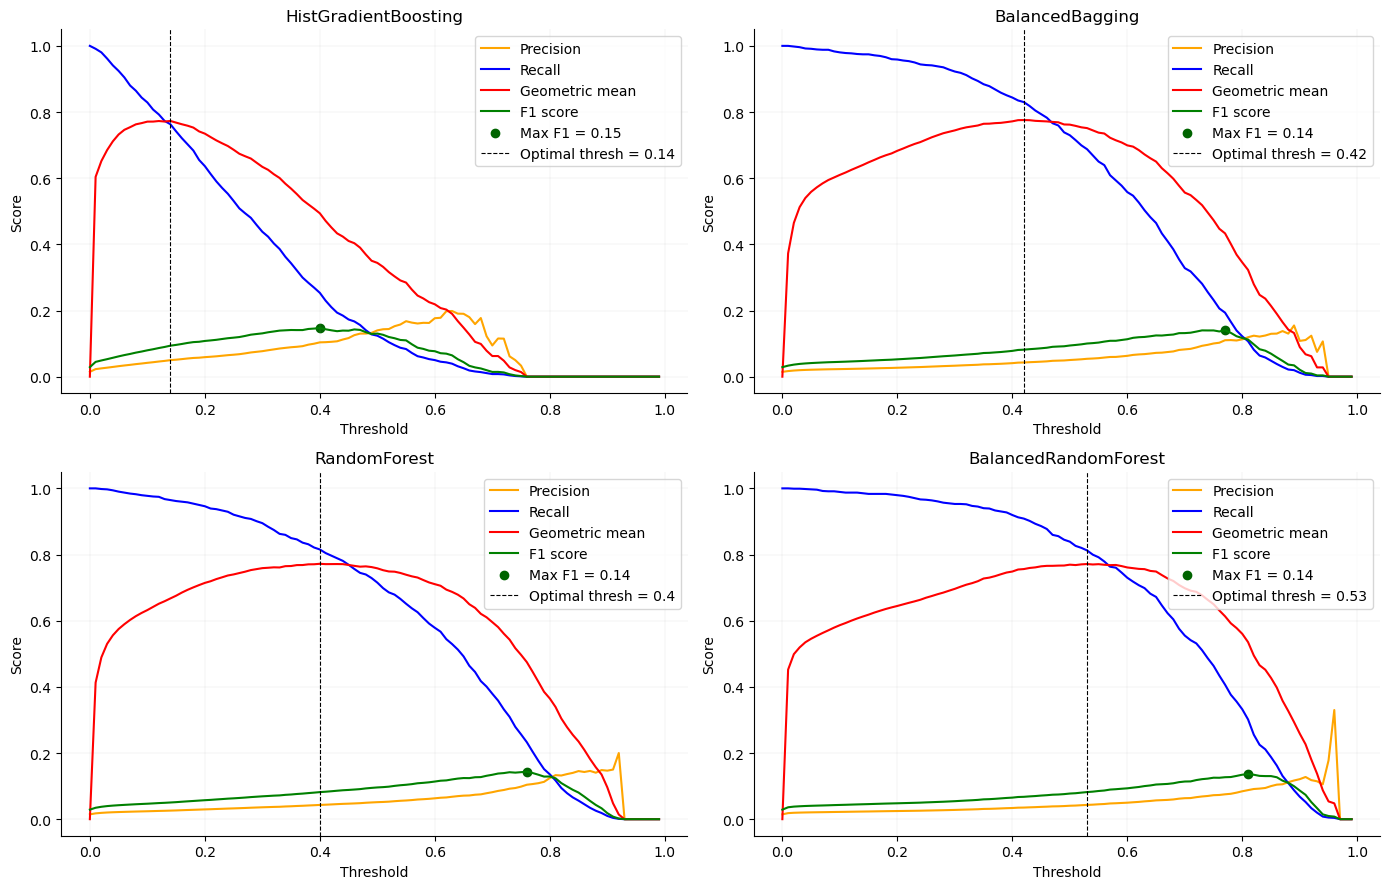

In [6]:
thresholds = np.arange(0, 1, 0.01)

_, optimal_thresholds = evaluate_discrimination_thresholds(estimators, 
                                                           X_train, y_train, 
                                                           thresholds)

None of the tested models prove to be effective classifiers, regardless of the applied threshold.

# Models evaluation on testing data

The classification thresholds determined in the previous step were used to evaluate the models on the test data. The ROC curves for each model are displayed below, with the thresholds marked. 

Subsequently, a bar chart provides a comparison of certain classification metrics. In addition to precision, recall, and F1 score, balanced accuracy is also shown, which is defined as the average of recall obtained for each class. Additionally, the percentage of observations classified as 1 is provided.

It should be emphasized that the classification thresholds applied here are merely reference points. In practice, it would be determined based on various business factors that are not provided.

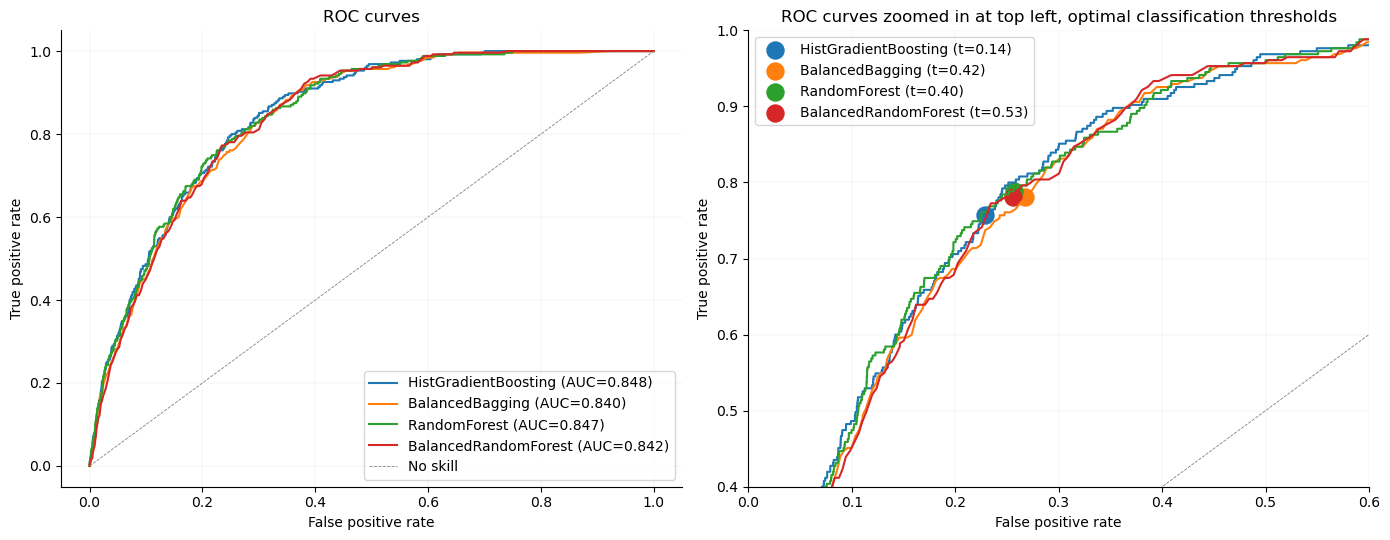

In [7]:
auc_scores = roc_curves(estimators, 
                        optimal_thresholds, 
                        X_train, X_test, y_train, y_test)

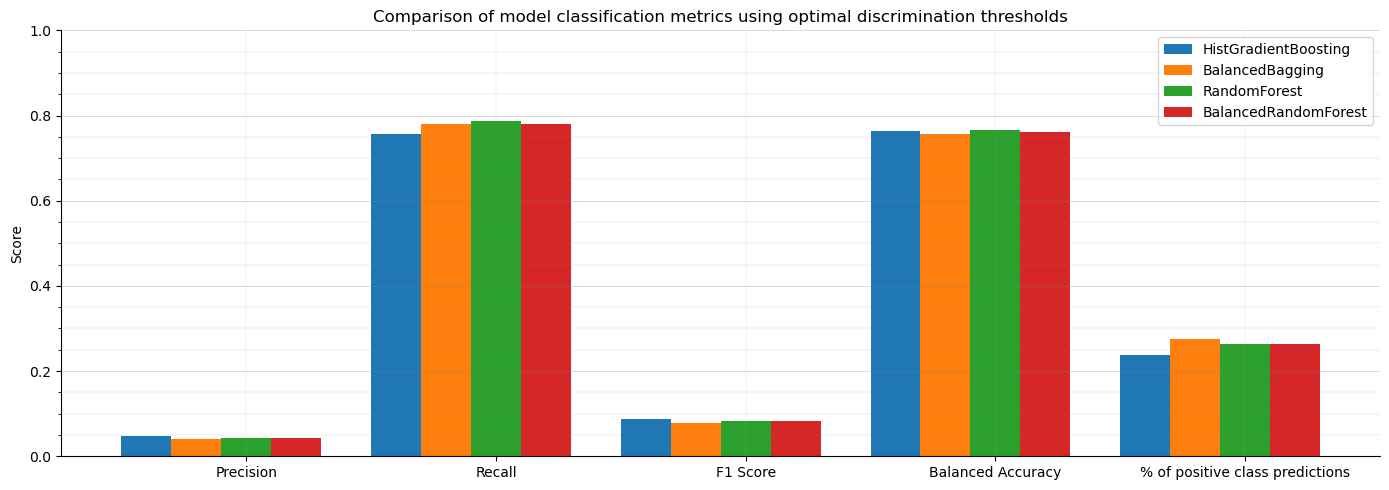

In [8]:
classification_metrics(estimators, 
                       optimal_thresholds,
                       X_train, X_test, y_train, y_test)

All of the tested estimators exhibit similar behavior across subsequent iterations, including similarities in classification metrics. With minor changes in data or hyperparameters, their ROC AUC rankings also vary.

In [9]:
display_final_results(estimators, auc_scores)

,ROC_AUC
HistGradientBoosting,0.8476
RandomForest,0.8469
BalancedRandomForest,0.8416
BalancedBagging,0.8403


In the presented case, the **Hist Gradient Boosting Classifier** achieved the highest auc score of 0.848. It was configured with a weight of 10 for the minority class, had no imputation and utilized 19 out of 20 features for prediction.